# Mapping Trends in Giovanni
***

## Mapping trends is an important concept and analysis in weather and climate. These are the types of maps the media to highlight phenomenas related climate change, like increasing temperature or drought.

## For our Giovanni statistics we already provide users with time series where they can plot a trendline. This would be an extension of this where the linear regressions are vectorized using python's SciPy linear regression package. 

### The example shown here maps the trend of Monthly Mean 2m air temperature from MERRA-2. Additionally we compute the anomalies to compare to analysis performed by NCEI/NOAA for February 2-m air temperatures for years 1987-2016. 

### The statistical significance of each trendline is also computed using SciPy. To compute the trend is actually only one more step from what Giovanni already provides, however, we need a few more statistics if we want to plot the signficance as well. 

***

### This was written in Python 3.12.9 and requires the following python packages and their dependencies installed. 

__Required:__
- numpy
- xarray
- scipy
- matplotlib
- glob (for gathering list of .nc4 files)

___Used for Plotting (Optional):___
- cmaps (NCL Colormaps)
- cartopy

#### GES DISC Data Used in Example

In this example we use 45 Years (1980-2024) of Monthly MERRA-2 2-m Air Temperature, downloaded from the [M2TMNXSLV_5.12.4 dataset](https://disc.gsfc.nasa.gov/datasets/M2TMNXSLV_5.12.4/summary) landing page.

We subset the Monthly Data by accessing the [dataset landing page](https://disc.gsfc.nasa.gov/datasets/M2TMNXSLV_5.12.4/summary) and subset via OPeNDAP using a bounding box of (-127.97,25.17,-66.97,50.83) and then download using one of the options from the [GES DISC Data Access FAQ](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Access%20GES%20DISC%20Data%20Using%20wget%20and%20curl). 

##### Importing Packages 

In [1]:
#Importing Packages
import glob
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

##### Gather List of Monthly Data Files and Open in Xarray

In [2]:
# Gathering Data Files for MERRA-2 Monthly 2m Air T (1980-2024)
air_T2m_files = glob.glob('C:/Users/bomitch1/Downloads/Giovanni_Stats_Examples/4/M2TMNXSLV.5.12.4%3AMERRA2_*.nc4')

# Opening Dataset into Xarray
T2m = xr.open_mfdataset(air_T2m_files)['T2M']
T2m

<xarray.DataArray 'T2M' (time: 540, lat: 53, lon: 99)> Size: 11MB
dask.array<concatenate, shape=(540, 53, 99), dtype=float32, chunksize=(1, 53, 99), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 792B -128.1 -127.5 -126.9 ... -68.12 -67.5 -66.88
  * time     (time) datetime64[ns] 4kB 1980-01-01T00:30:00 ... 2024-12-01T00:...
  * lat      (lat) float64 424B 25.0 25.5 26.0 26.5 27.0 ... 49.5 50.0 50.5 51.0
Attributes:
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

##### For this logic in Giovanni, users would be able to select a Month for example and do the trend analysis over time. This would require the following:
1. Access to those monthly files (so the same grabber as recurring time series averaging)
2. Be able to do the vectorization of linear regressions (calculate the trend (or linear regression) for each grid cell), performed later on in the notebook. 

In [3]:
#Selecting February Months
T2m_F = T2m.sel(time=T2m['time.month'] ==2)
T2m_F

<xarray.DataArray 'T2M' (time: 45, lat: 53, lon: 99)> Size: 944kB
dask.array<getitem, shape=(45, 53, 99), dtype=float32, chunksize=(1, 53, 99), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 792B -128.1 -127.5 -126.9 ... -68.12 -67.5 -66.88
  * time     (time) datetime64[ns] 360B 1980-02-01T00:30:00 ... 2024-02-01T00...
  * lat      (lat) float64 424B 25.0 25.5 26.0 26.5 27.0 ... 49.5 50.0 50.5 51.0
Attributes:
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

##### In this case I want the temperature trend from 1995-2024 (30 years)

In [4]:
#Monthly 2m Air T for February. 
T2m_F_period = T2m_F.sel(time= slice('1987','2016'))
T2m_F_period

<xarray.DataArray 'T2M' (time: 30, lat: 53, lon: 99)> Size: 630kB
dask.array<getitem, shape=(30, 53, 99), dtype=float32, chunksize=(1, 53, 99), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 792B -128.1 -127.5 -126.9 ... -68.12 -67.5 -66.88
  * time     (time) datetime64[ns] 240B 1987-02-01T00:30:00 ... 2016-02-01T00...
  * lat      (lat) float64 424B 25.0 25.5 26.0 26.5 27.0 ... 49.5 50.0 50.5 51.0
Attributes:
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

##### The following two steps are needed to compute the anomaly (for this exercise) but are not necessary for the feature implementation into Giovanni

In [7]:
#Selecting Early and Late Data (but we would only consider one)
T2m_F_mean = T2m_F.mean(dim='time') #Our Reference Climatology

#Compute the Anomalies for each February Monthly 2m Air T (Using entire MERRA-2 as reference)
T2m_F_anom = T2m_F_period - T2m_F_mean

##### The first part to our analysis is that we need to compute the linear regression. SciPy's stats.linregress function takes in an independent variable (x) and dependent variable (y) and returns the following statistics.

The following outputs are provided the following from [Scipy's linregress package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).
- __Slope:__ Which is the slope of the line and **is the only statistic needed to map the trend.**
- Intercept: The y-value at which the line produced crosses x=0
- R_value: The pearson correlation coefficient (square this value to obtain R^2)
- __p_value:__ The p-value for the hypothesis that a slope is zero. **This is needed for the significance testing.**
- stderr: The standard error of the _slope_. 

In [8]:
#We need to wrap our linear regression function which returns 5 functions
def scipy_linregress(x, y):  # Custom function wrapping scipy.stats.linregress
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

#### Next we need to create a time coordinate for the regression, otherwise the numerical units of time are expressed for the x coordinate. For example we would like our units to be years so creating a new coordinate that can mimic the time in between each map as one year works. 

##### Alternatively, you can use Pandas to convert the date to a format where then you are able to extract a list of years. For our purposes the years in the dataset are continuous with no gaps so the following array is the same logic. Note though that trends should be calculated over continous time series, discontinuties breaks the assumptions of the statistics that the nature of the data does not change over does not change. 

In [9]:
time_values = np.arange(len(T2m_F_anom['time']))

The following section of code utilizes __SciPy__ and __Xarray's apply_func__ function which allows us to apply a function to an xarray dataarray and receive the outputs. __Xarray apply_ufunc__ can be a little confusing so each line is commented to provide context into what the inputs we need to do the trend analysis are.

In [10]:
scipy_stats = xr.apply_ufunc(
    scipy_linregress,#SciPy linregress takes two arguments (x and y) those are the next two
                     #inputs for the analysis.
    time_values, # The independent variable for the regression (x)
    T2m_F_anom.load(), # The dependent variable or in this case our 3-D grid (x,lat,lon)
    
    #The following line is like saying for the lat and lon we want to go along the time dimension
    #which is important for the vectorize function
    input_core_dims=[['time'], ['time']],
    output_core_dims=[["scipy_lin"]], # Define a new dimension for the regression outputs which will be a list.
    vectorize=True, #  Applies the function to each grid cell which is what we want.
    output_sizes= 5, # Specify the size of the output dimension, this is the same as the length of the
                     # array returned from scipy.linregress [slope, int, r, p, std_err]
)
scipy_stats

<xarray.DataArray 'T2M' (lat: 53, lon: 99, scipy_lin: 5)> Size: 210kB
array([[[-5.03936530e-03, -8.21446602e-02, -7.27585027e-02,
          7.02395865e-01,  1.30545073e-02],
        [-5.48710128e-03, -6.76100934e-02, -8.15703587e-02,
          6.68279679e-01,  1.26701549e-02],
        [-6.25434511e-03, -4.89767055e-02, -9.25588938e-02,
          6.26633467e-01,  1.27149988e-02],
        ...,
        [ 1.20336547e-02, -2.86138587e-01,  1.65656466e-01,
          3.81655224e-01,  1.35384168e-02],
        [ 1.20297441e-02, -2.73160744e-01,  1.70498650e-01,
          3.67695111e-01,  1.31386407e-02],
        [ 1.21756039e-02, -2.72990960e-01,  1.74633083e-01,
          3.56016941e-01,  1.29735736e-02]],

       [[-6.60297194e-03, -5.30097601e-02, -9.53482859e-02,
          6.16232101e-01,  1.30275986e-02],
        [-5.80439583e-03, -5.95353998e-02, -8.61238156e-02,
          6.50895943e-01,  1.26893125e-02],
        [-5.37393844e-03, -5.84741666e-02, -7.95191155e-02,
          6.76166670e-01,  1.27310635e-02],
...
        [ 1.16702125e-01, -2.17446127e+00,  3.28357267e-01,
          7.64680218e-02,  6.34424173e-02],
        [ 1.15844387e-01, -2.15332761e+00,  3.33768314e-01,
          7.14614038e-02,  6.18306363e-02],
        [ 1.23127619e-01, -2.25525100e+00,  3.54664077e-01,
          5.44709016e-02,  6.13434210e-02]],

       [[ 1.77071339e-02, -4.70346033e-02,  1.23007779e-01,
          5.17256982e-01,  2.69976480e-02],
        [ 2.46003453e-02, -5.67497584e-02,  1.36246334e-01,
          4.72818473e-01,  3.38040364e-02],
        [ 2.93735390e-02, -7.21748479e-02,  1.42561910e-01,
          4.52342394e-01,  3.85402929e-02],
        ...,
        [ 1.21183680e-01, -2.25062345e+00,  3.32331855e-01,
          7.27650315e-02,  6.49949604e-02],
        [ 1.21947298e-01, -2.26661637e+00,  3.38163016e-01,
          6.75851826e-02,  6.41352937e-02],
        [ 1.25189742e-01, -2.30524301e+00,  3.47485956e-01,
          5.99044073e-02,  6.38424474e-02]]])
Coordinates:
  * lon      (lon) float64 792B -128.1 -127.5 -126.9 ... -68.12 -67.5 -66.88
  * lat      (lat) float64 424B 25.0 25.5 26.0 26.5 27.0 ... 49.5 50.0 50.5 51.0
Dimensions without coordinates: scipy_lin

##### The resulting dataset array is formed which is the same size lat (53) and lon (99) as our other data_arrays. The only difference is now we have a dimension with a length of 5 named "scipy_lin" which we named in the function above. This contains the outputs of our five variables in order of how we arranged them in our "scipy_linregress" function. But you can think of this data array as 5 maps with containing the slope, intercept, r, p, and std_err. 

##### To call each one of these we would have to remember their exact position [0,1,2,3,4], however for more intuivtive use of this data array, let's rename our "scipy_lin" coordinate values so it's easier to call which scipy_stat variable we would like to plot below. 

In [11]:
scipy_stats['scipy_lin'] = ['slope','int','r','p','std_error']
scipy_stats

<xarray.DataArray 'T2M' (lat: 53, lon: 99, scipy_lin: 5)> Size: 210kB
array([[[-5.03936530e-03, -8.21446602e-02, -7.27585027e-02,
          7.02395865e-01,  1.30545073e-02],
        [-5.48710128e-03, -6.76100934e-02, -8.15703587e-02,
          6.68279679e-01,  1.26701549e-02],
        [-6.25434511e-03, -4.89767055e-02, -9.25588938e-02,
          6.26633467e-01,  1.27149988e-02],
        ...,
        [ 1.20336547e-02, -2.86138587e-01,  1.65656466e-01,
          3.81655224e-01,  1.35384168e-02],
        [ 1.20297441e-02, -2.73160744e-01,  1.70498650e-01,
          3.67695111e-01,  1.31386407e-02],
        [ 1.21756039e-02, -2.72990960e-01,  1.74633083e-01,
          3.56016941e-01,  1.29735736e-02]],

       [[-6.60297194e-03, -5.30097601e-02, -9.53482859e-02,
          6.16232101e-01,  1.30275986e-02],
        [-5.80439583e-03, -5.95353998e-02, -8.61238156e-02,
          6.50895943e-01,  1.26893125e-02],
        [-5.37393844e-03, -5.84741666e-02, -7.95191155e-02,
          6.76166670e-01,  1.27310635e-02],
...
        [ 1.16702125e-01, -2.17446127e+00,  3.28357267e-01,
          7.64680218e-02,  6.34424173e-02],
        [ 1.15844387e-01, -2.15332761e+00,  3.33768314e-01,
          7.14614038e-02,  6.18306363e-02],
        [ 1.23127619e-01, -2.25525100e+00,  3.54664077e-01,
          5.44709016e-02,  6.13434210e-02]],

       [[ 1.77071339e-02, -4.70346033e-02,  1.23007779e-01,
          5.17256982e-01,  2.69976480e-02],
        [ 2.46003453e-02, -5.67497584e-02,  1.36246334e-01,
          4.72818473e-01,  3.38040364e-02],
        [ 2.93735390e-02, -7.21748479e-02,  1.42561910e-01,
          4.52342394e-01,  3.85402929e-02],
        ...,
        [ 1.21183680e-01, -2.25062345e+00,  3.32331855e-01,
          7.27650315e-02,  6.49949604e-02],
        [ 1.21947298e-01, -2.26661637e+00,  3.38163016e-01,
          6.75851826e-02,  6.41352937e-02],
        [ 1.25189742e-01, -2.30524301e+00,  3.47485956e-01,
          5.99044073e-02,  6.38424474e-02]]])
Coordinates:
  * lon        (lon) float64 792B -128.1 -127.5 -126.9 ... -68.12 -67.5 -66.88
  * lat        (lat) float64 424B 25.0 25.5 26.0 26.5 ... 49.5 50.0 50.5 51.0
  * scipy_lin  (scipy_lin) <U9 180B 'slope' 'int' 'r' 'p' 'std_error'

##### Function for Map Plots

In [15]:
def plot_map(da,title,rows,cols,plot_num,cmaps,pmin,pmax):
    ax1 = plt.subplot(rows,cols,plot_num+1)

    #Set Map Extent
    ax1.set_extent([-127, -68, 26, 48])

    #Add Map Features
    ax1.coastlines(resolution='10m')
    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.OCEAN)
    ax1.add_feature(cfeature.LAKES)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.STATES, edgecolor='black')
    ax1.grid(linestyle='dotted')

    #Create and Format Ticks
    ax1.set_yticks(np.arange(30,46,5), crs=ccrs.PlateCarree())
    ax1.set_xticks(np.arange(-125,-70,20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    #Plot the values inside the map
    grid = da.plot.imshow(ax=ax1,cmap=cmaps,add_colorbar=False,vmin=pmin,vmax=pmax)
    
    #Add the Plot Title and X and Y axis labels along with font sizes
    ax1.set_title(title, size=10, fontweight='bold')
    ax1.set_xlabel("Longitude",  size=10)
    ax1.set_ylabel("Latitude", size=10)
    ax1.tick_params(axis='x', labelsize=10)  
    ax1.tick_params(axis='y', labelsize=10) 

    return(grid)

##### Plotting the Trend in the Temperature Anomalies

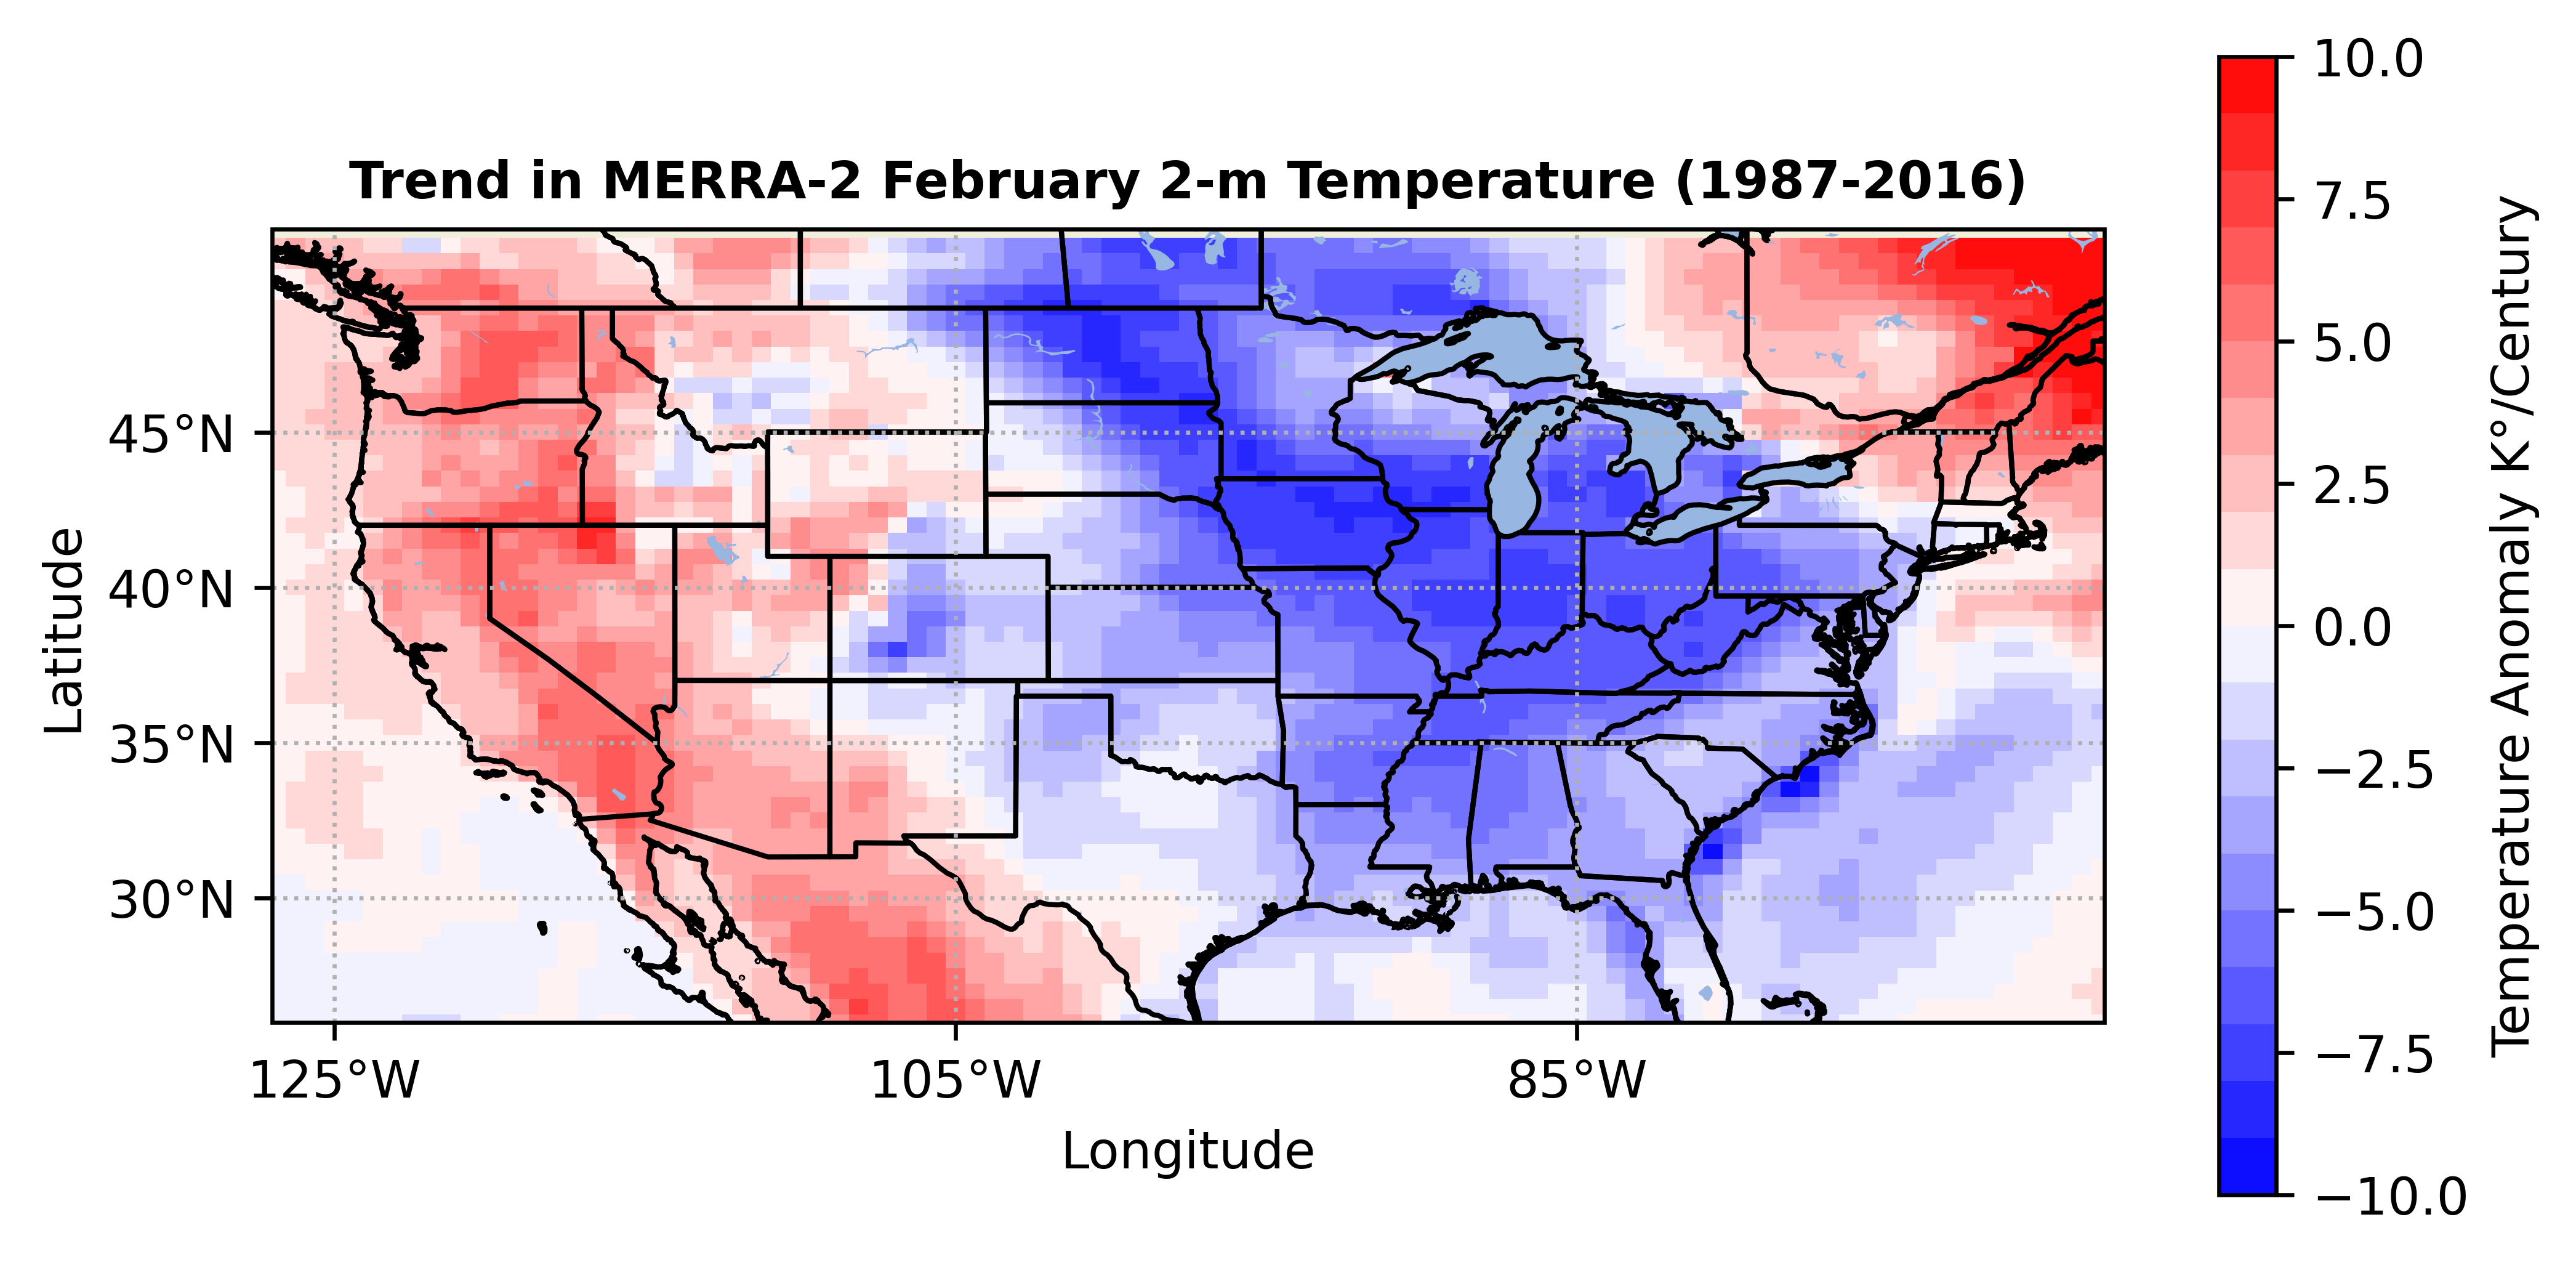

In [20]:
#Right now our trend is in K/year but another function that could be added would be to allow users
#to specify what the trend unit they would like (i.e., per decade)

trend_denom = 100

fig, ax1 = plt.subplots(1,1,figsize=(8,4),subplot_kw={"projection": ccrs.PlateCarree()},
                          dpi=600)
grid = plot_map(scipy_stats.sel(scipy_lin='slope')*trend_denom,'Trend in MERRA-2 February 2-m Temperature (1987-2016)',
                1,1,0,cmaps.GMT_polar,-10,10)

cb = plt.colorbar(grid, ax=ax1, orientation = 'vertical', label='Temperature Anomaly K\u00B0/Century')

#### Now similar our anomaly trend plot looks like there's quite the trend for the and that is consistent with the temperature anomaly trend from NCEI/NOAA


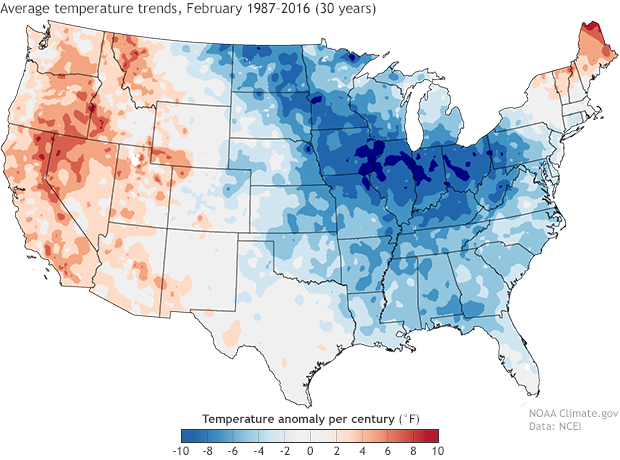

[Source: climate.gov](https://www.climate.gov/news-features/blogs/beyond-data/mapping-us-climate-trends)

#### But let's see if any of these trends are signficant...

##### Plotting the Trend in the Temperature Anomalies at 95% confidence interval

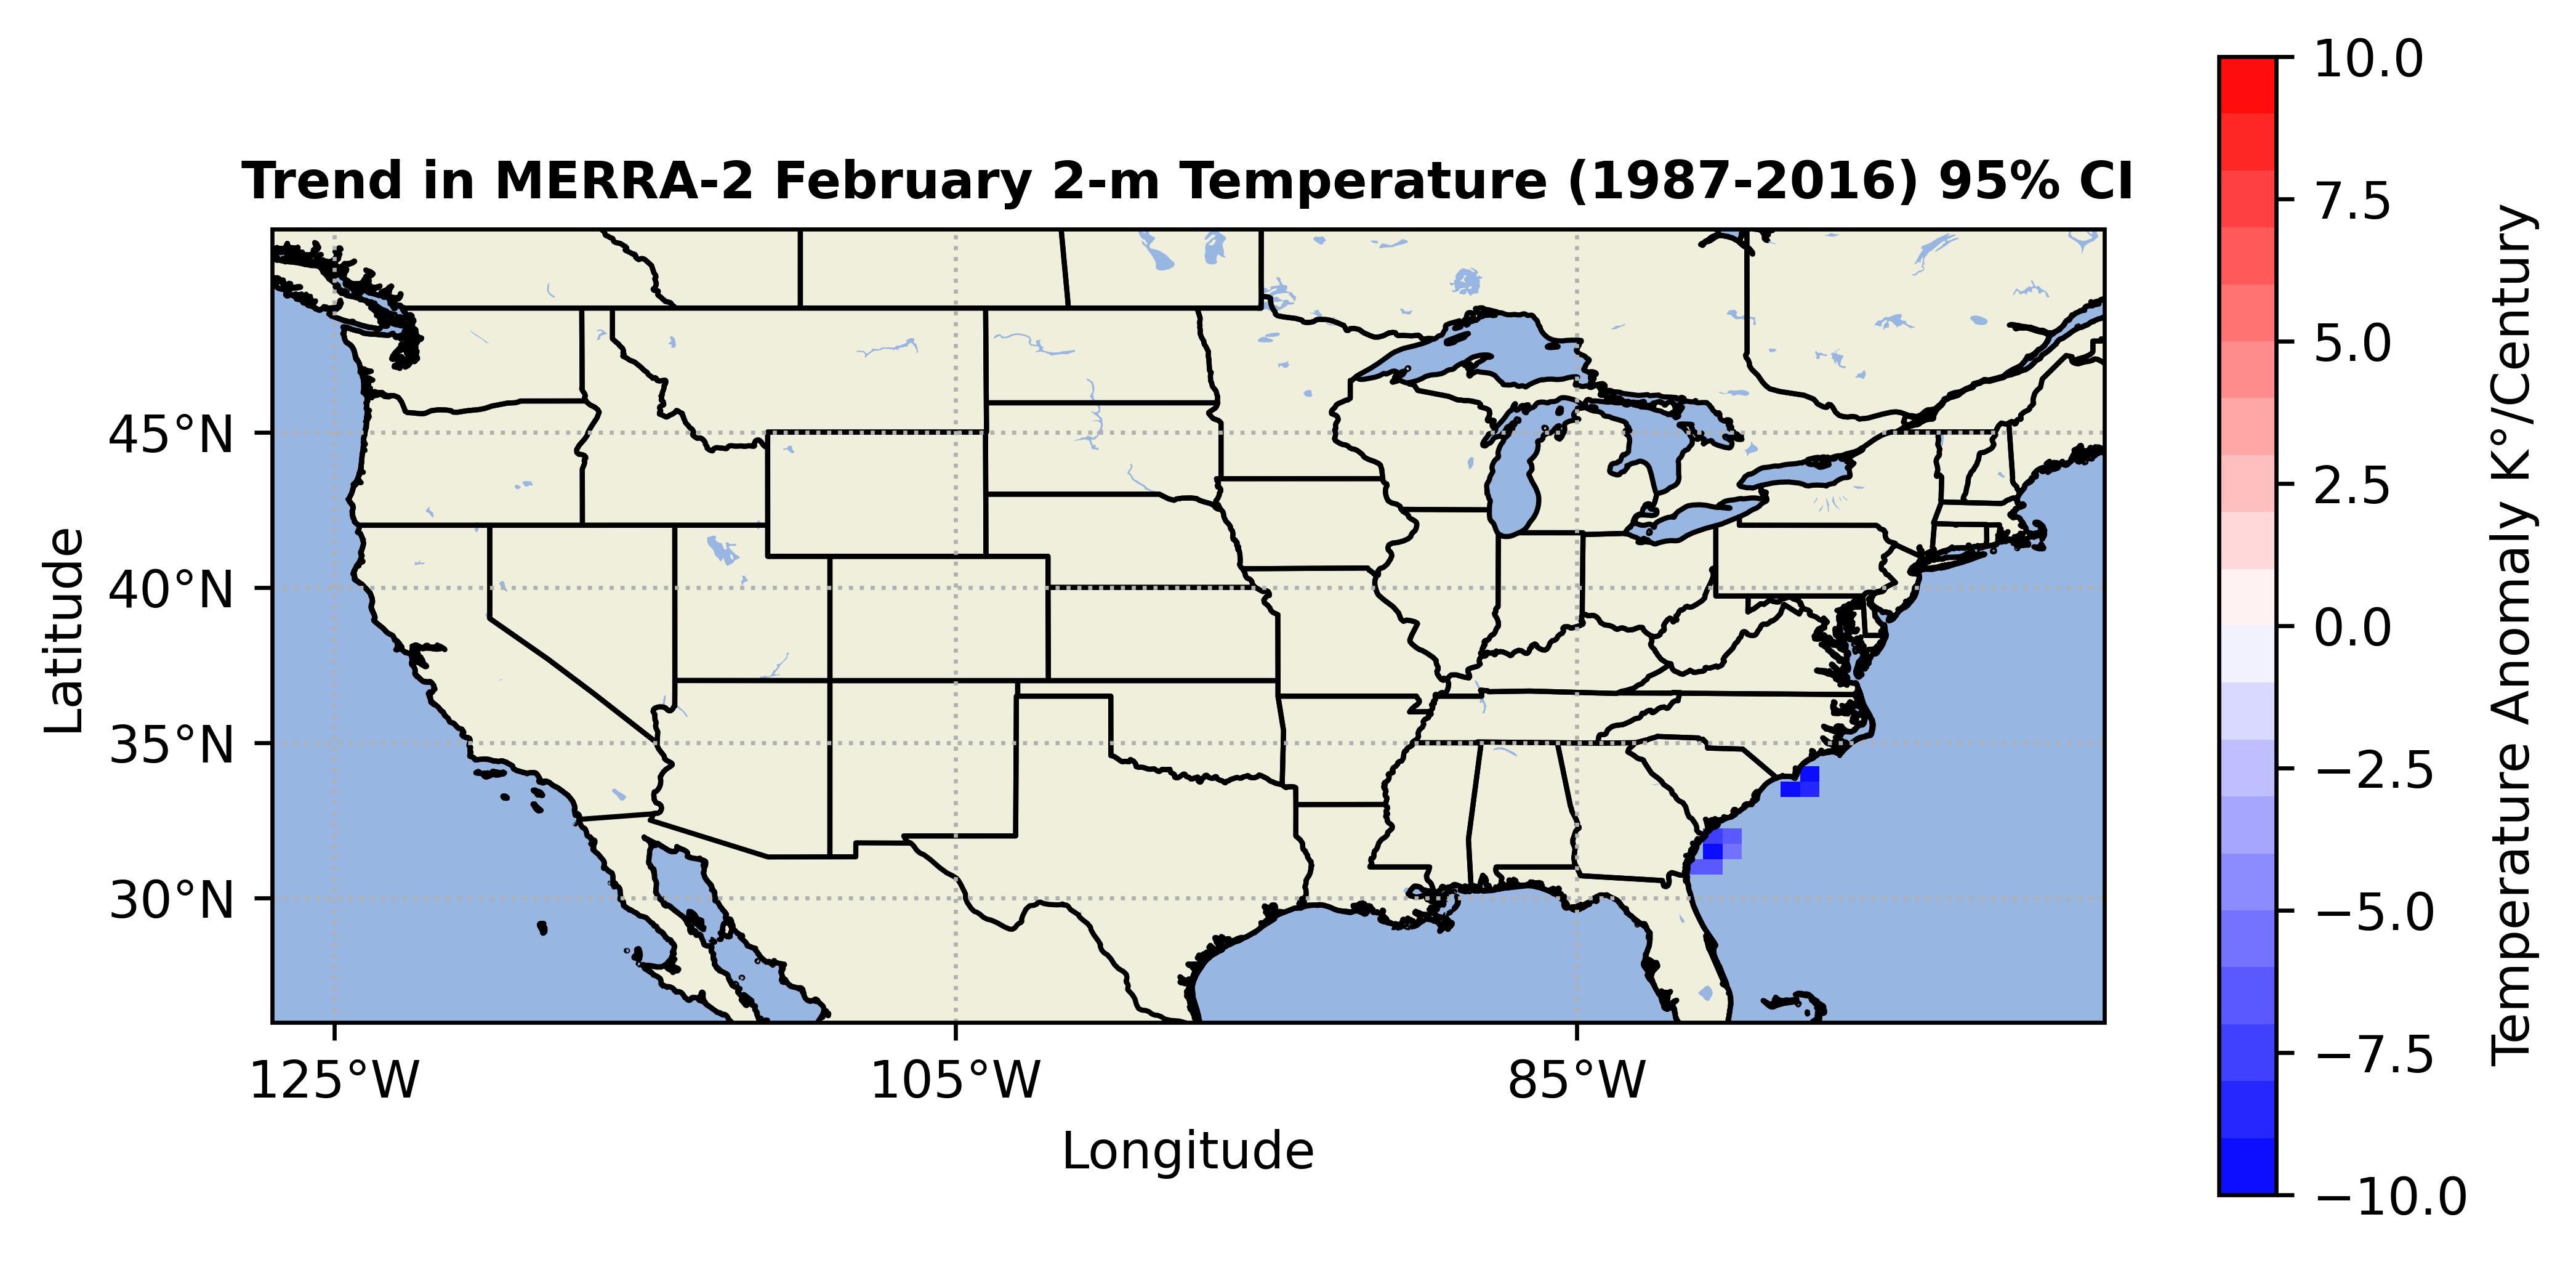

In [21]:
#95% Confidence Interval (CI) (i.e., where p <= 0.025 on 2-tail test)
p_95=0.05 #represents 95% CI 
p_95_2_sided = p_95/2

fig, ax1 = plt.subplots(1,1,figsize=(8,4),subplot_kw={"projection": ccrs.PlateCarree()},
                          dpi=600)

grid = plot_map((scipy_stats.sel(scipy_lin='slope')*trend_denom).where(abs(scipy_stats.sel(scipy_lin='p').values) <= p_95_2_sided),
                'Trend in MERRA-2 February 2-m Temperature (1987-2016) 95% CI',
                1,1,0,cmaps.GMT_polar,-10,10)

cb = plt.colorbar(grid, ax=ax1, orientation = 'vertical', label='Temperature Anomaly K\u00B0/Century ')

#### Now we see that at many places the trend is not significant for this period... 

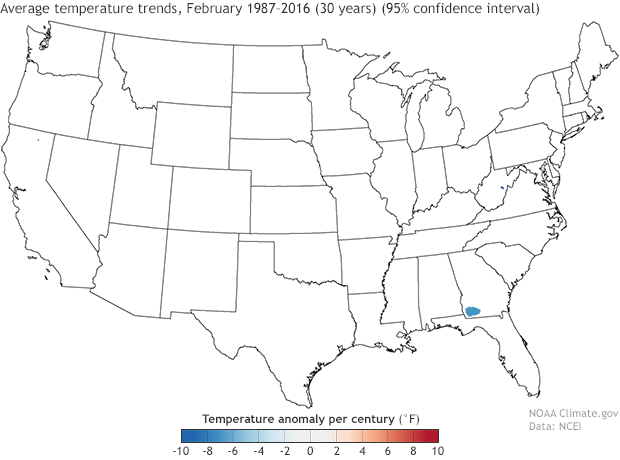

#### However, with more years of data the trends we see with our eyes become more reliable and looking at our February temperature trends from 1895-2016 we do see that we are indeed warming and by quite a bit in Northern states this past century.

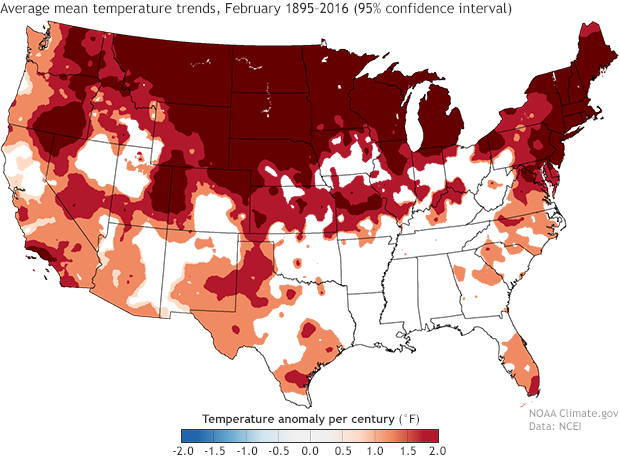

#### Currently our NASA datasets such as MERRA-2 are at a stage where we have decades of information and we can confidently compute climatologies of different variables, and as the datasets become longer in record we can begin to calculate these multi-decadal trends and test their significance. 

[Source: climate.gov](https://www.climate.gov/news-features/blogs/beyond-data/mapping-us-climate-trends)
